# Crowd Counting Prediction
This notebook is used for prediction only

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the imports

In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import scipy
from scipy import spatial
from scipy import ndimage

import tensorflow as tf
import keras
from keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose, ReLU, Activation, BatchNormalization,Lambda
from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16
import keras.backend as K

## Load Dataset

### Run this code only when you are using Colab
This code will download dataset needed to colab's temporary storage

#### Install PyDrive

#### Google Drive Authentication

#### Download the file from the link

##### Download images file in `.npy` format from this [link](https://drive.google.com/file/d/1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF/view)

##### Download density map file that has been generated for images in the dataset from this [link](https://drive.google.com/file/d/1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT/view)

### Load dataset from file

In [3]:
import imutils
import  cv2
from imutils import paths
import matplotlib.pyplot as plt
def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []
	# loop over the image paths
	for imagePath in imagePaths:
		image = cv2.imread(imagePath)
		data.append(image)
	return np.array(data, dtype="float32")

In [4]:
import glob
import imutils
import  cv2
import os
from imutils import paths
def load_gt(datasetPath):
  path_sets = [datasetPath]
  img_paths = []
  for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
  print(len(img_paths))
  data=[]
  img_paths = eval('img_paths')
  for img_path in tqdm(img_paths):
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_'))
    gt = pts["image_info"][0, 0][0, 0][0]
    data.append(gt)
  return data

In [6]:
from numpy import genfromtxt
from scipy.io import loadmat
image = '/content/drive/My Drive/images/images'
images = load_dataset(image)
print(np.shape(images))
label = ('/content/drive/My Drive/labels.csv')
labels = genfromtxt(label, delimiter=',')
print(np.shape(labels))
images_gt = load_gt(image)
images_density=np.load('/content/drive/My Drive/images_density.npy')
print('ok')

 42%|████▏     | 83/200 [00:00<00:00, 825.12it/s]

(200, 480, 640, 3)
(200, 2)
200


100%|██████████| 200/200 [00:00<00:00, 809.73it/s]


ok


## Data Preview

### Images

In [7]:
images=images/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


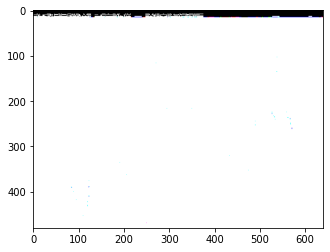

In [7]:
img=plt.imshow(images[40])

### Images + Density Map

number of people: 21.57


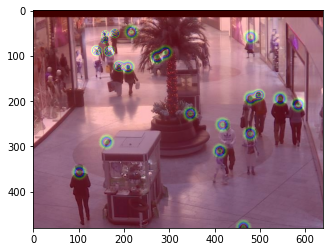

In [9]:
plt.imshow(images[40])
plt.imshow(images_density[40],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[40]/1000))

## Model definition

### Import VGG16 as Baseline
Set the input shape for our model\
Creating baseline model with VGG16

In [7]:
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

### Main Model Architecture

In [8]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model
    
    
    
    
    
    
    


### SSIM and Euclidean Loss + Custom MAE metrics

In [9]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)

### Define the Model

#### Download the model weight

#### Model declaration

In [10]:
lr=1e-5
model=Crowd_CNN()
model.load_weights("/content/drive/My Drive/Colab Notebooks/Crowd-CNN")
Optimizer=Nadam(lr)
# model.summary()

#### Compile Model

In [11]:
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

## Create test data and predict
This section include pre-process data that is used for prediction\
We provide two ways of prediction, which is image from mall dataset or image that we can upload ourselves

### Data from mall dataset
data will be selected randomly

#### Select random data
Randomly selected data will be saved on variable X and y for input and label with size of `test_size`

test size is number of image that we want to predict

In [12]:
test_size = 2

In [13]:
idx_test = np.random.randint(images.shape[0], size=test_size)
idx_test

array([ 37, 140])

In [14]:
X = images[idx_test]/255  # normalize
y = images_density[idx_test]

#### Selected Image Data Preview

number of people: 17.00


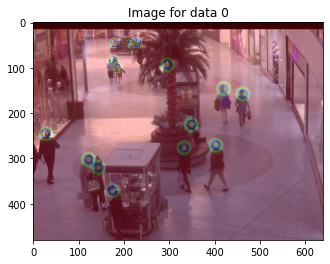

In [15]:
plt.title("Image for data 0")
plt.imshow(X[0])
plt.imshow(y[0],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[0]/1000))

number of people: 33.00


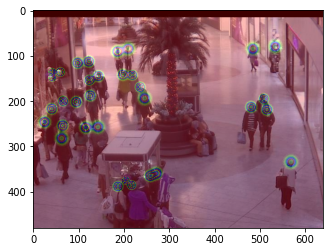

In [16]:
plt.imshow(X[1])
plt.imshow(y[1],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[1]/1000))

#### Prediction

##### Pre-process data for prediction

In [17]:
y = np.expand_dims(y,-1)
y.shape

(2, 480, 640, 1)

##### Function for predicting on input image(s)

In [18]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

##### Prediction for all input images (`X`)

In [19]:
for i in range(0, test_size):

  y_predict = full_eval(X[i:i+1],smooth=True)

  print("Prediction for data {}".format(i))
  print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
  print('Exact Number of people: %4.2f' %(np.sum(y[i])/1000))
  print()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Prediction for data 0
Predicted Number of people: 29.43
Exact Number of people: 17.00

Prediction for data 1
Predicted Number of people: 35.13
Exact Number of people: 33.00



##### Prediction per single image

Predicted Number of people: 29.43
Exact Number of people: 17.00


<Figure size 432x288 with 0 Axes>

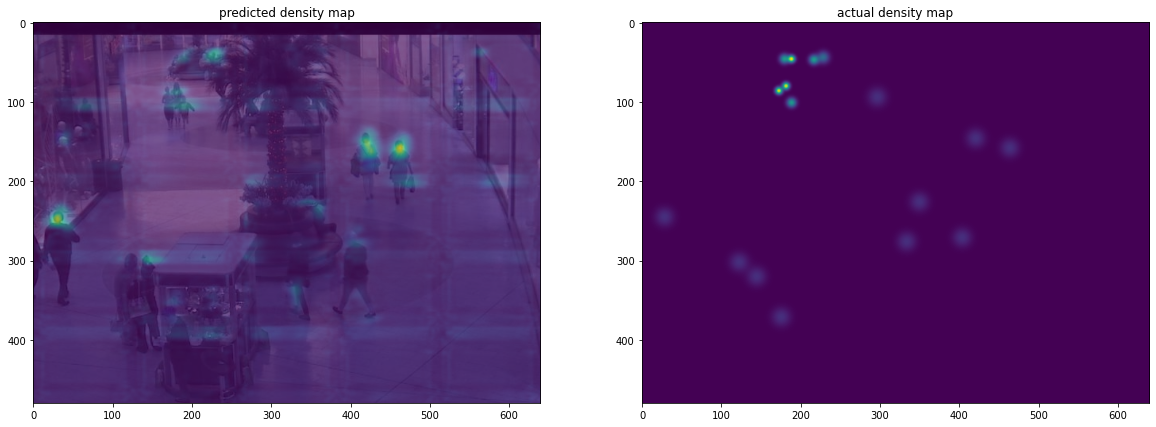

In [20]:
e=0
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

# plot for predicted density map
axarr[0].title.set_text('predicted density map')
axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict, alpha=0.7)

# plot for actual density map
axarr[1].title.set_text('actual density map')
axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))


Predicted Number of people: 35.13
Exact Number of people: 33.00


<Figure size 432x288 with 0 Axes>

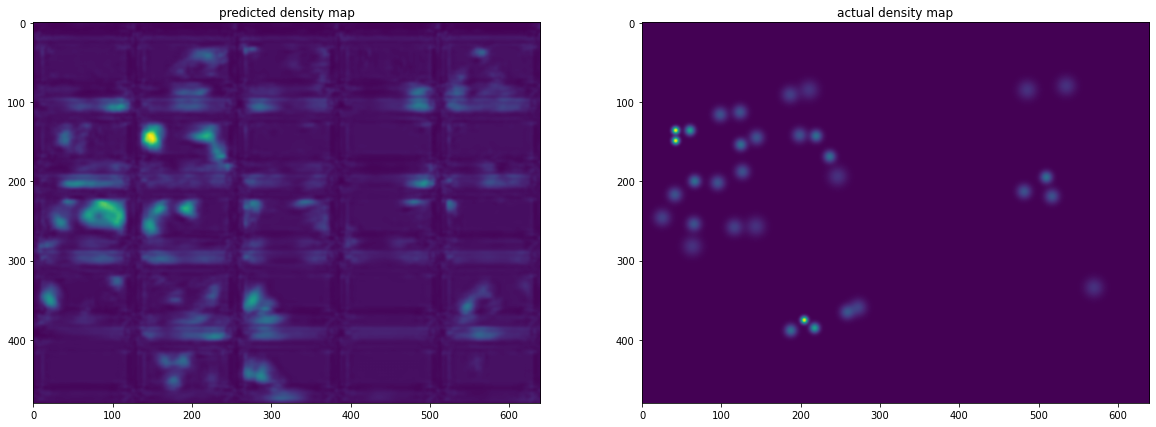

In [21]:
e=1
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

# plot for predicted density map
axarr[0].title.set_text('predicted density map')
# axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict)

# plot for actual density map
axarr[1].title.set_text('actual density map')
# axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))


### Data uploaded from user

In [25]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # pre-process image
  path = '/content/' + fn
  img = image.load_img(path, target_size=(480, 640))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images[0] = images[0] / 255

  # predicting images
  y_predict = full_eval(images,smooth=True)

  print("\nPrediction for data {}".format(fn))
  print('Predicted Number of people: %4.2f\n' %(np.sum(y_predict)/1000))



Saving IMG_1.jpg to IMG_1.jpg

Prediction for data IMG_1.jpg
Predicted Number of people: 29.51

